In [241]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output, FileLink, FileLinks
import collections
import urllib
from os import listdir
from os.path import isfile, join
import pandas
import re

### Data preparation, helper functions, setup

In [138]:
#source: https://daten.berlin.de/datensaetze/liste-der-h%C3%A4ufigen-vornamen-2015

fileurllist = ['http://www.berlin.de/daten/liste-der-vornamen-2015/charlottenburg-wilmersdorf.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/friedrichshain-kreuzberg.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/lichtenberg.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/marzahn-hellersdorf.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/mitte.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/neukoelln.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/pankow.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/reinickendorf.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/spandau.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/steglitz-zehlendorf.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/tempelhof-schoeneberg.csv',
              'http://www.berlin.de/daten/liste-der-vornamen-2015/treptow-koepenick.csv']

!mkdir name-csvs/
for url in fileurllist:
    file_name = url.split('/')[-1]
    full_path = 'name-csvs/' + file_name
    urllib.urlretrieve(url, full_path)

Build a proper text file for training

In [217]:
def build_training_data(gender="w", districts="all", weighted=False):
    # returns one string, names separated by \n, names randomized, repetitions across districts NOT removed
    raw_names = ''
    if (districts == "all"): 
        fileslist = [f for f in listdir('name-csvs/') if isfile(join('name-csvs/', f))]
        print "loading all districts in folder :"  + str(files_in_dir)
    
    else:#better check if is list
        print "loading districts as specified in list: " + str(districts)
        fileslist = districts
        
    for idx,current_file in enumerate(fileslist):
        temp_df = pandas.read_csv(join('name-csvs/', current_file),';')     
        if idx == 0:
            full_df = temp_df
            
        if (weighted == True):
            df_append = temp_df
            for iteration in range(max(temp_df.anzahl)):
                df_append = df_append.append(temp_df.loc[temp_df.anzahl>=iteration])
            temp_df = df_append
            
        full_df = full_df.append(temp_df)
    
    full_df.reset_index(drop = True, inplace = True)
    raw_names = re.sub(pattern = r' |\d',repl='', string = full_df.reindex(np.random.permutation(full_df.index)).loc[full_df['geschlecht'] == gender].vorname.to_string())
 
    return raw_names, full_df

In [145]:
my_districts = ['lichtenberg.csv', 'marzahn-hellersdorf.csv', 'neukoelln.csv', 'reinickendorf.csv']

In [144]:
names_w_all_districts, _  = build_training_data()

loading all districts (in folder)


In [218]:
names_w_my_districts, test_df = build_training_data(gender = 'w', districts= my_districts, weighted=True)

loading districts as specified in list: ['lichtenberg.csv', 'marzahn-hellersdorf.csv', 'neukoelln.csv', 'reinickendorf.csv']


In [219]:
len(names_w_my_districts)

107037

In [220]:
test_df.shape

(31432, 3)

In [223]:
vocab = list(set(names_w_my_districts))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in names_w_my_districts]

In [238]:
Dimensions = collections.namedtuple("Dimensions","vocab_size num_neurons, num_steps, batch_size")

dimensions = Dimensions(vocab_size = len(vocab),
                        num_neurons = 500,
                        num_steps = 50,
                        batch_size = 10*128)

In [225]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [226]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

### Define the graph

In [227]:
GraphOps = collections.namedtuple("GraphOps","x y learning_rate train prediction init_state state accuracy loss init")

In [236]:
def build_graph(dims):    
    
    tf.reset_default_graph()
    
    #----------input layer-----------------------
    x = tf.placeholder(tf.int64, [None, dims.num_steps],name="x")
    y = tf.placeholder(tf.int64, [None, dims.num_steps],name="y")
    #init_state = tf.placeholder(tf.float32,[None, num_neurons])
    learning_rate = tf.placeholder(tf.float32,[])

    embeddings = tf.get_variable('embedding_matrix', [dims.vocab_size, dims.num_neurons])

    # Tensor of dims batch_size //num_steps x num_steps x num_neurons
    x_transformed = tf.nn.embedding_lookup(embeddings, x)

    #----------hidden layer-----------------------
    cell = tf.nn.rnn_cell.LSTMCell(dims.num_neurons, state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * 3, state_is_tuple=True)
    init_state = cell.zero_state(dims.batch_size//dims.num_steps,tf.float32)
    rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_transformed, initial_state=init_state, dtype=tf.float32)

    #----------output layer-----------------------
    weight = tf.Variable(tf.truncated_normal([dims.num_neurons, dims.vocab_size], stddev=0.1))
    bias = tf.Variable(tf.constant(0.0, shape=[dims.vocab_size]))

    output = tf.reshape(rnn_output, [-1, dims.num_neurons])
    logits = tf.matmul(output, weight) + bias
    prediction = tf.nn.softmax(logits)
    prediction = tf.reshape(prediction, [-1, dims.num_steps, dims.vocab_size])

    #----------loss and accuracy------------------
    target = tf.reshape(y,[-1])
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 2),y), tf.float32))

    #----------Trainer------------------
    trainOp = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    init_vars = tf.initialize_all_variables()
    
    return GraphOps(x=x, y=y, learning_rate=learning_rate, train=trainOp, prediction=prediction, init_state=init_state, state=final_state, accuracy=accuracy, loss=loss, init=init_vars)


### train the model

In [246]:
print_after_num_steps = 10
adaptive_learning_rate = 0.01
training_state = None

trainHist = []
accHist = []

trainingOps = build_graph(dimensions)

sess = tf.Session()
sess.run(trainingOps.init)

for num_epoch, epoch in enumerate(gen_epochs(raw_text_enc,30,dimensions.batch_size,dimensions.num_steps)):
    
    if num_epoch > 30:
        adaptive_learning_rate = 0.001
    
    for i, batch in enumerate(epoch):
        
        feed_dic = {trainingOps.x: batch[0], trainingOps.y: batch[1], trainingOps.learning_rate: adaptive_learning_rate}
        if training_state is not None:
            feed_dic = {trainingOps.x: batch[0], trainingOps.y: batch[1], trainingOps.learning_rate: adaptive_learning_rate, trainingOps.init_state: training_state}
        acc, lossVal, training_state, _ = sess.run([trainingOps.accuracy, trainingOps.loss, trainingOps.state, trainingOps.train], feed_dict=feed_dic)
        trainHist.append(lossVal)
        accHist.append(acc)
        
        if i % print_after_num_steps == 0:
            clear_output()
            avg_loss = sum(trainHist[-print_after_num_steps:])/print_after_num_steps
            avg_acc = sum(accHist[-print_after_num_steps:])/print_after_num_steps
            logstring = 'Epoch: '+ str(num_epoch) + ' step: ' + str(i) +' loss: ' + str(avg_loss) + ' accuracy: ' + str(avg_acc) + '\n'
            print(logstring)
            with open("name_gen_log.txt", "a") as myfile:
                myfile.write(logstring)

Epoch: 29 step: 80 loss: 1.62644296885 accuracy: 0.494479995966



In [248]:
saver = tf.train.Saver()
saver.save(sess, 'lstm_rnn_name_gen.tf_vars')
FileLink('lstm_rnn_name_gen.tf_vars')

/notebooks/lstm_rnn_name_gen.tf_vars

In [249]:
FileLink('lstm_rnn_name_gen.tf_vars.meta')

/notebooks/lstm_rnn_name_gen.tf_vars.meta

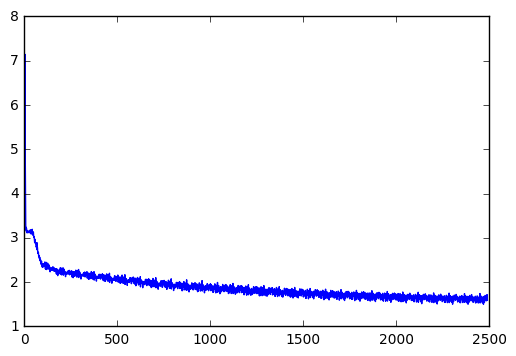

In [250]:
plt.plot(trainHist[:])

### generate names
some notes:

- "The temperature is dividing the predicted log probabilities before the Softmax, so lower temperature will cause the model to make more likely, but also more boring and conservative predictions. Higher temperatures cause the model to take more chances and increase diversity of results, but at a cost of more mistakes."

- make sure generated name is not in training set (use pandas df)

In [251]:
#rebuild the graph:
gen_dimensions = Dimensions(vocab_size = dimensions.vocab_size, 
                            num_neurons = dimensions.num_neurons, 
                            num_steps = 1,
                            batch_size = 1)

gen_ops = build_graph(gen_dimensions)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

saver = tf.train.Saver()
saver.restore(sess, 'lstm_rnn_name_gen.tf_vars')

prev = np.array([[trans_dic['x']]])

generated_names = ''
pred_hist = []

for i in range(1000):
    if i == 0:
        pred, state = sess.run([gen_ops.prediction,gen_ops.state],feed_dict={gen_ops.x: prev})
    else:
        pred, state = sess.run([gen_ops.prediction,gen_ops.state],feed_dict={gen_ops.x: prev, gen_ops.init_state: state})
    
    pred_hist.append(pred)
    prev = rev_trans_dic[np.random.choice(gen_dimensions.vocab_size,1,p=np.squeeze(pred)).flatten()[0]]
    generated_names += prev
    prev = np.array([[trans_dic[prev]]])

In [252]:
print(generated_names)

xïărorhhariah
Emma
Josice
Flora
Gelda
Catala
Lurgin
Charlotta
Maria
Luria
Carlote
Greta
Edora
Frittietta
Dace
Janija
Nazbalea
Zile
Leyle
Sophie
Annelie
Ipalina
Meara
Hiberlu
Virria
Sanephine
Amelie
Bir
Alicu
Raja
Emely
Emilie
Isale
Roe-Sole
Dilay
Clara
Charlotte
Lena
Elna
Andrere
Laria
Wile
Emilia
Lasie
Leana
Joli
Freta
Nikoléne
Ingelly
Ella
Kamira
Calistina
Gatıma
Eya
Hohaslici
Sofie
Claisha
Laja
Merén
Naja
Le
Alina
Helena
Daila-Luise
Lino
Gera
Aurgin
Malya
Saline
Mera
Jasmin
Amelha
Krisoà
Laie
Leoida
Harina
Jaurem
Lya
Nazmin
Meroja
Sura
Sharota
Lena
Merlin
Angelie
Ly
Greti
Laureeselike
Saire
Karina
Joyan
Faabea
Luta
Zoéelle
Minh
Loise
Krarlotta
Emily
Lyny
Marie
Amanicha
Aleonou
Lane
Valeria
Caya
Alija
Lilin
Hele
Fa
Elhelen
Ragine
Angelia
Averia
Ozabelle
Suth
Linjeker
Noe
Naro
Jusephine
Lea
Mar
Dines-Zoéce
Evom
Emily
Jae
Jote
Maria
Shanor
Pathrenova
Aşra
Madith
Emaore
Nejnna
Liese
Semayne
Harnophin
Amy
Selien
Lunu
Lenny
Marie
Jina
Negin
Efely
Rosalie
Tahkén
Emilia
Charlotte
Navy
Stans

### store & send